In [3]:
# import machine learning and data science libarires
import pandas as pd
import numpy as np

# import Google Finance API libraries
from googlefinance.client import get_price_data

# import data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (15, 5)

# import other libraries
import datetime as dt
import time

In [216]:
# set all the tickers: choose between: 'AAPL', 'MSFT', AMZN'
my_ticker = 'AAPL'

# set all the parameters
my_params = {
'q': my_ticker,    #stock symbol (ex: "AAPL")
'i': "86400",      #interval size in seconds ("86400" = 1 day intervals)
'x': "INDEXNASD",  #stock exchange symbol on which stock is traded (ex: "NASD")
'p': "5Y"          #period (ex: "1Y" = 1 year)
}

# build the dataframe of the stock data
my_stck = get_price_data(my_params)

# reset the indexes
#my_stck = my_stck.reset_index()

# print the head of my dataframe
print(my_stck.head())

                        Open     High      Low    Close     Volume
2012-10-18 16:00:00  91.3700  91.7200  90.0000  90.3800  119155512
2012-10-19 16:00:00  90.1500  90.2500  87.0900  87.1200  186021017
2012-10-22 16:00:00  87.4900  90.7700  87.2500  90.5800  136682392
2012-10-23 16:00:00  90.1429  90.5571  87.3857  87.6222  176786197
2012-10-24 16:00:00  88.7800  89.5100  87.2300  88.1200  139631772


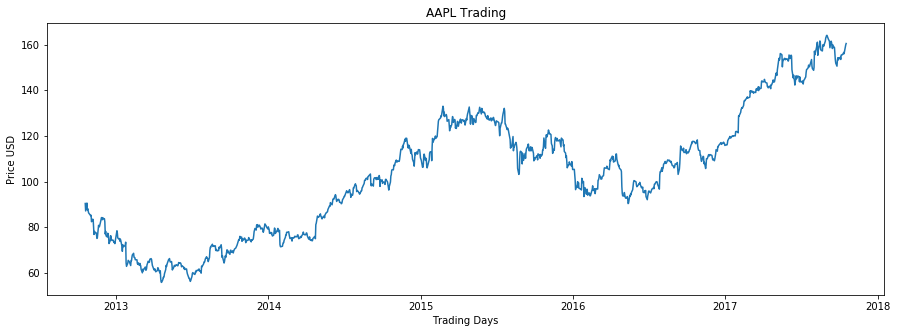

In [217]:
# plot data
fig, ax = plt.subplots()
ax.plot(my_stck.index, my_stck['Close'])

# format the y-crd label
price = lambda y : '$%1.2f' % y
ax.format_ydata = price

# format the x-crd label
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title(my_ticker + ' Trading')

# set labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

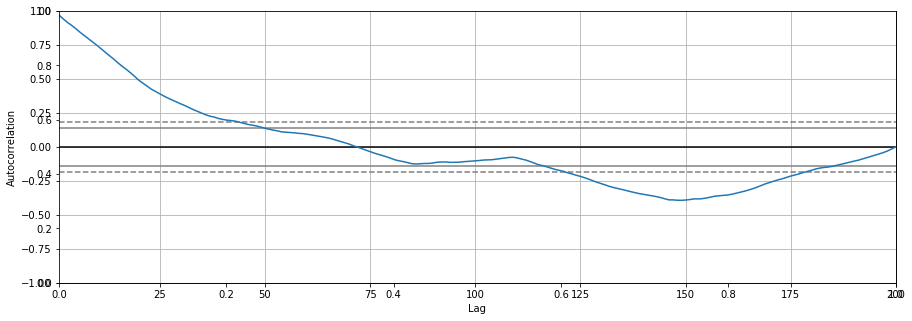

In [263]:
# my_series
my_series = my_stck['Close'][-200:]

#
from pandas.plotting import autocorrelation_plot as acf_pl
plt.subplots()

acf_pl(my_series)
plt.show()

#
#from statsmodels.graphics.tsaplots import plot_acf as acf_pl2
#acf_pl2(my_series)
#plt.show()

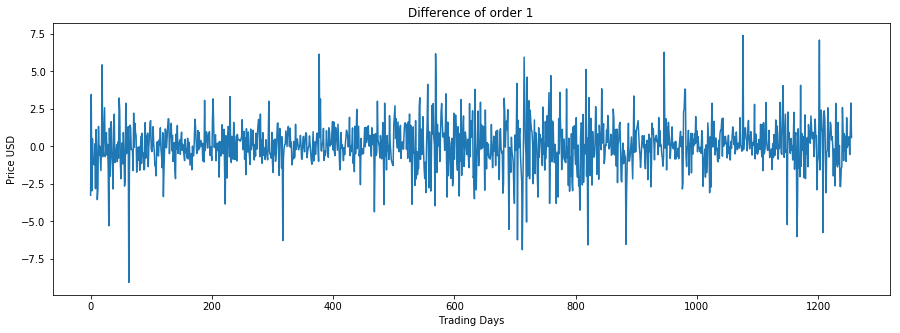

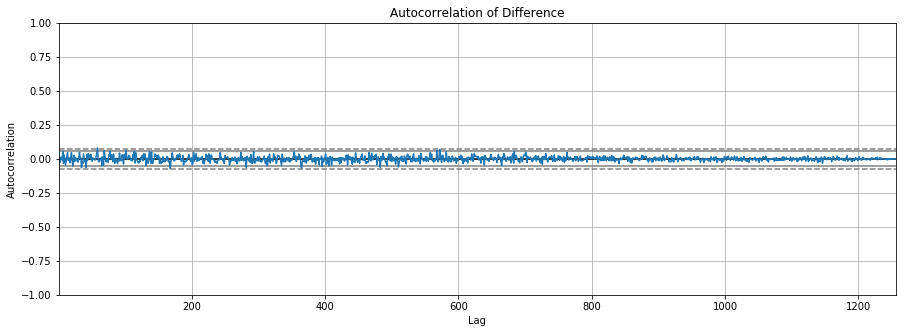

In [256]:
#
diff_values = my_stck['Close'][1:].values-my_stck['Close'][:-1].values
plt.title('Difference of order 1')
plt.plot(diff_values)
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
plt.show()

acf_pl(diff_values)
plt.title('Autocorrelation of Difference')
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  199
Model:                ARIMA(10, 1, 1)   Log Likelihood                -367.893
Method:                       css-mle   S.D. of innovations              1.535
Date:                Tue, 17 Oct 2017   AIC                            761.787
Time:                        23:44:56   BIC                            804.600
Sample:                    01-04-2017   HQIC                           779.114
                         - 10-17-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2270      0.123      1.852      0.066      -0.013       0.467
ar.L1.D.Close      0.2014      0.563      0.358      0.721      -0.901       1.304
ar.L2.D.Close     -0.0232      0.072

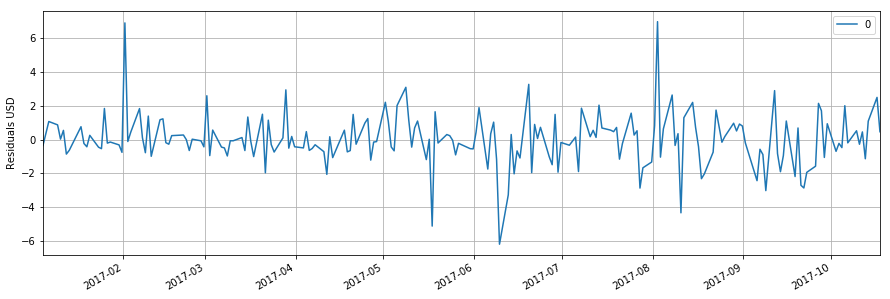

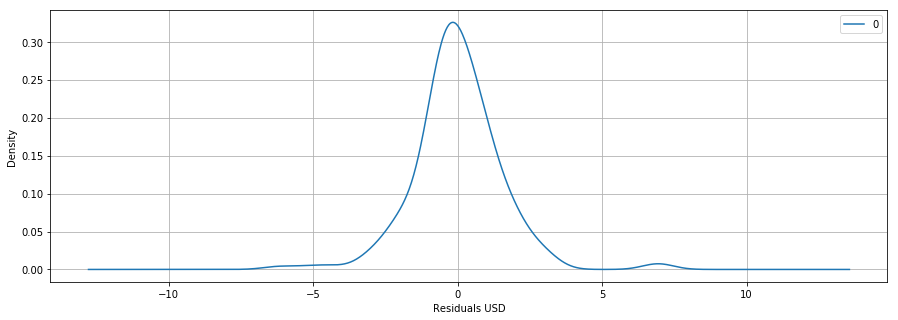

                0
count  199.000000
mean    -0.001161
std      1.539387
min     -6.194186
25%     -0.709354
50%     -0.092237
75%      0.740504
max      6.975047


In [258]:
#
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(my_series, order=(10,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.grid()
plt.ylabel('Residuals USD')
plt.show()

residuals.plot(kind='kde')
plt.xlabel('Residuals USD')
plt.grid()
plt.show()
print(residuals.describe())

In [237]:
from sklearn.metrics import mean_squared_error

X = my_series.values
#size = int(len(X) * 0.66)
#train, test = X[0:size], X[size:len(X)]
size = len(X)-50
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=160.790715, expected=160.080000
predicted=160.536892, expected=161.060000
predicted=159.912835, expected=155.320000
predicted=156.174223, expected=157.480000
predicted=157.492783, expected=159.850000
predicted=160.524760, expected=161.600000
predicted=161.180600, expected=160.950000
predicted=160.407317, expected=157.860000
predicted=160.435050, expected=157.500000
predicted=158.273366, expected=157.210000
predicted=157.766826, expected=159.780000
predicted=158.980026, expected=159.980000
predicted=159.388409, expected=159.270000
predicted=159.841517, expected=159.860000
predicted=160.607913, expected=161.470000
predicted=162.529776, expected=162.910000
predicted=162.318812, expected=163.350000
predicted=163.131721, expected=164.000000
predicted=164.341909, expected=164.050000
predicted=164.583183, expected=162.080000
predicted=162.512713, expected=161.910000
predicted=162.191347, expected=161.260000
predicted=161.721643, expected=158.630000
predicted=158.534513, expected=161

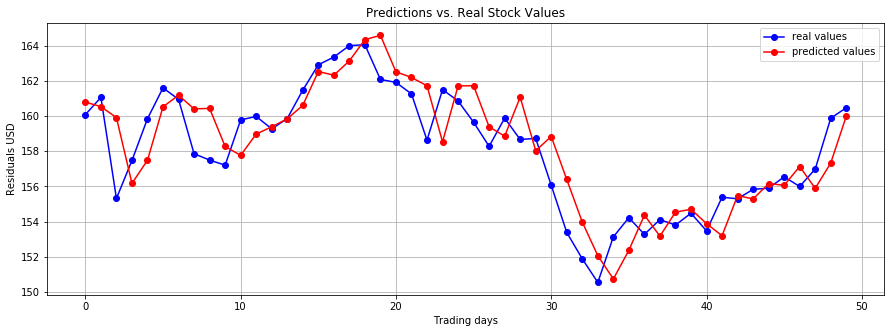

In [260]:
# plot
plt.subplots()
plt.plot(test, 'o-', color='b', label='real values')
plt.plot(predictions, 'o-', color='red', label='predicted values')
plt.title('Predictions vs. Real Stock Values')
plt.ylabel('Residuals USD')
plt.xlabel('Trading days')
plt.legend()
plt.grid()
plt.show()

In [261]:
def stock_variant(test_list):
    ans_ = test_list[1:]*100 - test_list[:-1]*100
    return np.sign(ans_*100)

test_var = stock_variant(np.array(test))
predict_var = stock_variant(np.array(predictions))

guesses = test_var*predict_var[0,:]
correctness = sum(guesses == 1)/(sum(guesses == 1)+sum(guesses == -1))*100

print('precision = %1.0f ' % (correctness))

precision = 47 
